
--- Classical Models ---
Random Forest: 1.00
SVM: 0.62
MLP: 0.46

--- Quantum Model ---


c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\pennylane\_grad.py:310: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


Quantum VQC: 0.46


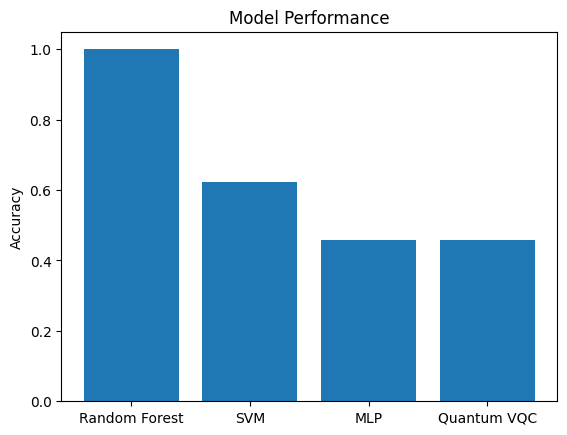

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Try importing PennyLane (quantum)
try:
    import pennylane as qml
    pennylane_available = True
except ImportError:
    pennylane_available = False


# -----------------------------
# 1. DATA PREPARATION
# -----------------------------
def load_data():
    np.random.seed(42)
    n = 200
    dates = pd.date_range(start="2021-01-01", periods=n, freq="D")
    prices = np.cumprod(1 + 0.001 * np.random.randn(n)) * 100  # random walk

    df = pd.DataFrame({"Date": dates, "Close": prices})
    df["Return"] = df["Close"].pct_change()
    df["SMA_5"] = df["Close"].rolling(5).mean()
    df["SMA_20"] = df["Close"].rolling(20).mean()
    df["Direction"] = (df["Return"] > 0).astype(int)  # target: 1=up, 0=down
    df.dropna(inplace=True)

    X = df[["Close", "Return", "SMA_5", "SMA_20"]]
    y = df["Direction"]
    return train_test_split(X, y, test_size=0.2, shuffle=False)


# -----------------------------
# 2. CLASSICAL MODELS
# -----------------------------
def train_classical_models(X_train, X_test, y_train, y_test):
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=100),
        "SVM": SVC(),
        "MLP": MLPClassifier(max_iter=1000)
    }

    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        results[name] = accuracy_score(y_test, preds)
    return results


# -----------------------------
# 3. QUANTUM MODEL (OPTIONAL)
# -----------------------------
def train_quantum_model(X_train, X_test, y_train, y_test):
    if not pennylane_available:
        return None

    n_qubits = 2
    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev)
    def circuit(features, weights):
        # Encode features into quantum states
        qml.AngleEmbedding(features[:n_qubits], wires=range(n_qubits))
        qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

    weights = np.random.randn(3, n_qubits, 3)  # trainable parameters
    opt = qml.AdamOptimizer(0.1)
    epochs = 5  # keep small for demo

    def classical_loss(weights):
        loss = 0
        for xi, yi in zip(X_train.values, y_train):
            output = np.mean(circuit(xi, weights))  # prediction
            loss += (output - yi) ** 2
        return loss / len(X_train)

    # Training loop
    for _ in range(epochs):
        weights, loss = opt.step_and_cost(classical_loss, weights)

    preds = []
    for xi in X_test.values:
        out = np.mean(circuit(xi, weights))
        preds.append(1 if out > 0 else 0)

    return accuracy_score(y_test, preds)


# -----------------------------
# 4. MAIN PIPELINE
# -----------------------------
if __name__ == "__main__":
    X_train, X_test, y_train, y_test = load_data()

    print("\n--- Classical Models ---")
    classical_results = train_classical_models(X_train, X_test, y_train, y_test)
    for name, acc in classical_results.items():
        print(f"{name}: {acc:.2f}")

    if pennylane_available:
        print("\n--- Quantum Model ---")
        q_acc = train_quantum_model(X_train, X_test, y_train, y_test)
        print(f"Quantum VQC: {q_acc:.2f}")
    else:
        print("\nQuantum model skipped (PennyLane not installed).")

    # Plot accuracies
    all_results = classical_results.copy()
    if pennylane_available and q_acc is not None:
        all_results["Quantum VQC"] = q_acc

    plt.bar(all_results.keys(), all_results.values())
    plt.ylabel("Accuracy")
    plt.title("Model Performance")
    plt.show()
